<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/data-exploration/training_at_level_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install tf-nightly-2.0-preview

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190512


### Global constants

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 160 
BATCH_SIZE = 25

CLASS_MODE = 'categorical'

NUM_OF_CLASSES = 2
CLASS_NAMES = ['tumor', 'non_tumor']


### Setting up GCP

In [0]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

In [5]:
!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


### Read Data from GCP

In [0]:
LEVEL = 7

In [0]:
TRAIN_DIR = "/tmp/train/"
GCP_TRAIN_DIR = "train/level{}/".format(LEVEL)
LEVEL_TRAIN_DIR = "/tmp/train/level{}".format(LEVEL)

VAL_DIR = "/tmp/validate/"
GCP_VAL_DIR = "validate/level{}/".format(LEVEL)
LEVEL_VAL_DIR = "/tmp/validate/level{}".format(LEVEL)

TEST_DIR = "/tmp/test/"
GCP_TEST_DIR = "test/level{}/".format(LEVEL)
LEVEL_TEST_DIR = "/tmp/test/level{}".format(LEVEL)

In [0]:
# !rm -rf '$TRAIN_DIR'
# !rm -rf '$VAL_DIR'
# !rm -rf '$TEST_DIR'

# !mkdir -p '$TRAIN_DIR'
# !mkdir -p '$VAL_DIR'
# !mkdir -p '$TEST_DIR'

### Download Training set

In [9]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TRAIN_DIR} {TRAIN_DIR}
  
print("\nDownloaded Train Data")

print("# Non Tumor files")
!ls "$LEVEL_TRAIN_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TRAIN_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_0_0_250_tumor_091.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_0_0_250_tumor_096.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_0_64000_250_tumor_001.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_0_32000_250_tumor_096.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_128000_250_tumor_059.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_160000_250_tumor_005.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_32000_250_tumor_084.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_32000_250_tumor_096.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_64000_250_tumor_001.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_96000_250_tumor_001.tif...
Copying gs://vaa2114_dl_2019/train/level7/non_tumor/level_7_32000_96000_250_tumor_012.tif...

### Download Validation Set

In [10]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_VAL_DIR} {VAL_DIR}
 
print("\nDownloaded Validation Data")

print("# Non Tumor files")
!ls "$LEVEL_VAL_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_VAL_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_0_160000_250_tumor_016.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_32000_0_250_tumor_101.tif...
Copying gs://vaa2114_dl_2019/validate/level7/non_tumor/level_7_32000_96000_250_tumor_016.tif...
Copying gs://vaa2114_dl_2019/validate/level7/non_tumor/level_7_0_0_250_tumor_081.tif...
Copying gs://vaa2114_dl_2019/validate/level7/non_tumor/level_7_0_32000_250_tumor_081.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_32000_128000_250_tumor_016.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_0_0_250_tumor_101.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_0_128000_250_tumor_057.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_32000_160000_250_tumor_016.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_32000_32000_250_tumor_081.tif...
Copying gs://vaa2114_dl_2019/validate/level7/tumor/level_7_32000_32000_250_tumor_101.tif...
Copy

### Download Test Set

In [11]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TEST_DIR} {TEST_DIR}
 
print("\nDownloaded Test Data")

print("# Non Tumor files")
!ls "$LEVEL_TEST_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TEST_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/test/level7/non_tumor/level_7_0_0_250_tumor_094.tif...
Copying gs://vaa2114_dl_2019/test/level7/non_tumor/level_7_32000_64000_250_tumor_094.tif...
Copying gs://vaa2114_dl_2019/test/level7/tumor/level_7_32000_32000_250_tumor_094.tif...
Copying gs://vaa2114_dl_2019/test/level7/tumor/level_7_64000_0_250_tumor_094.tif...
Copying gs://vaa2114_dl_2019/test/level7/tumor/level_7_64000_32000_250_tumor_094.tif...
Copying gs://vaa2114_dl_2019/test/level7/tumor/level_7_32000_64000_250_tumor_035.tif...
Copying gs://vaa2114_dl_2019/test/level7/tumor/level_7_32000_96000_250_tumor_035.tif...
/ [7/7 files][  1.0 MiB/  1.0 MiB] 100% Done                                    
Operation completed over 7 objects/1.0 MiB.                                      

Downloaded Test Data
# Non Tumor files
2
# Tumor files
5


In [12]:
train_tumor_dir = os.path.join(LEVEL_TRAIN_DIR, "tumor")
train_non_tumor_dir = os.path.join(LEVEL_TRAIN_DIR, "non_tumor")

val_tumor_dir = os.path.join(LEVEL_VAL_DIR, "tumor")
val_non_tumor_dir = os.path.join(LEVEL_VAL_DIR, "non_tumor")

test_tumor_dir = os.path.join(LEVEL_TEST_DIR, "tumor")
test_non_tumor_dir = os.path.join(LEVEL_TEST_DIR, "non_tumor")


tot_train_tumor = len(os.listdir(train_tumor_dir))
tot_train_non_tumor = len(os.listdir(train_non_tumor_dir))

tot_val_tumor = len(os.listdir(val_tumor_dir))
tot_val_non_tumor = len(os.listdir(val_non_tumor_dir))

tot_test_tumor = len(os.listdir(test_tumor_dir))
tot_test_non_tumor = len(os.listdir(test_non_tumor_dir))

total_train = tot_train_tumor + tot_train_non_tumor
total_val = tot_val_tumor + tot_val_non_tumor
total_test = tot_test_tumor + tot_test_non_tumor

print("Total Train:", total_train)
print("Total Val:", total_val)
print("Total Test:", total_test)


Total Train: 45
Total Val: 14
Total Test: 7


### Extracting the Window size from the file name


In [13]:
WINDOW = int(os.listdir(train_tumor_dir)[0].split('_')[4])
print("SLIDING WINDOW SIZE: ", WINDOW)

SLIDING WINDOW SIZE:  250


### Util functions

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def getModel(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(216, activation='relu'))
  model.add(Dense(NUM_OF_CLASSES, activation='softmax'))
  
  return model

In [0]:
# Compile and build

def trainModel(model, total_train, total_val, 
               train_data_gen, val_data_gen, EPOCHS):
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

  history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
        verbose=2)
  
  return history

In [0]:
# Print Train/Validate accuracy and loss

def plotTrainVal(history, EPOCHS):

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, EPOCHS+1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Image Generators w/ Data Augmentation

Rerun before each model training

In [40]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 160
BATCH_SIZE = 10
NUM_CLASSES = 2
CLASS_MODE = 'categorical'

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# image_gen_train = ImageDataGenerator(rescale=1./255)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TRAIN_DIR, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode=CLASS_MODE)


# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_VAL_DIR,                     
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)

# Test data should not be augmented!
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TEST_DIR, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)


Found 45 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


### Sample Training Data after Data Augmentation

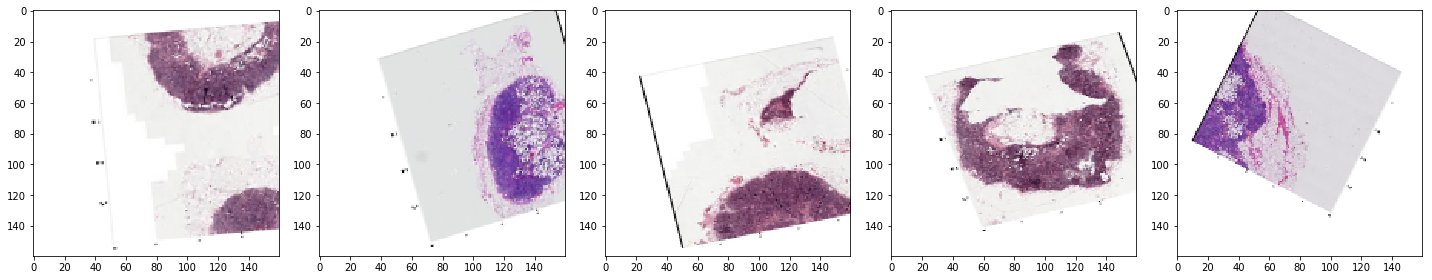

In [41]:
sample_training_images, sample_training_labels = next(train_data_gen)

plotImages(sample_training_images[:5])

### Sample Validation data

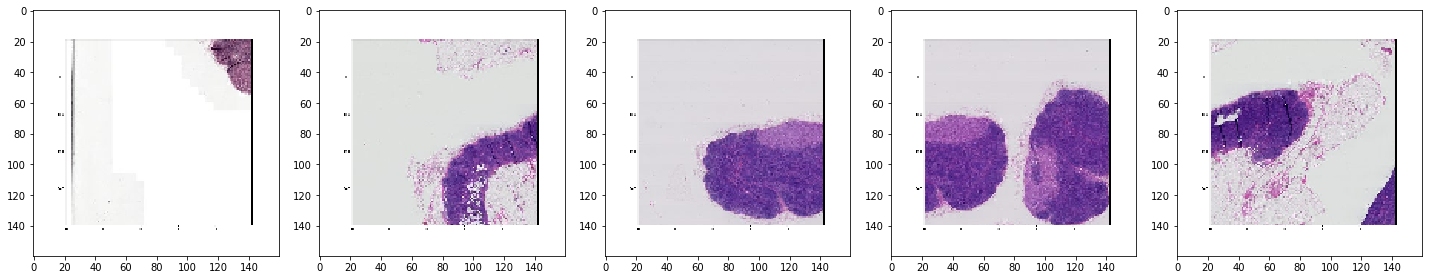

In [42]:
sample_val_images, sample_val_labels = next(val_data_gen)

plotImages(sample_val_images[:5])

### Sample Test Data

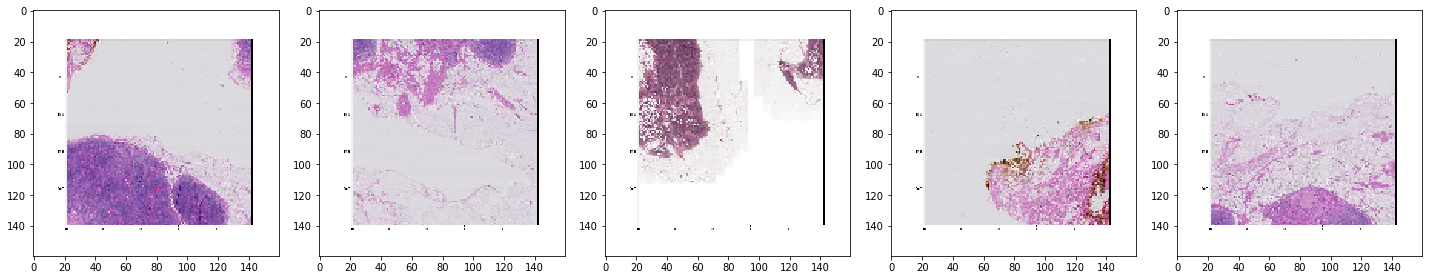

In [43]:
sample_test_images, sample_test_labels = next(test_data_gen)

plotImages(sample_test_images[:5])

### Train with Mobile Net

In [0]:
mobile_net = applications.MobileNet(weights='imagenet',include_top=False, input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

conv_base = mobile_net
conv_base.trainable = False

model_mobile = getModel(conv_base)

In [45]:
model_mobile.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Model)   (None, 5, 5, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 216)               5529816   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 434       
Total params: 8,759,114
Trainable params: 5,530,250
Non-trainable params: 3,228,864
_________________________________________________________________


In [46]:
%%time

EPOCHS = 20

history_mobile = trainModel(model_mobile, total_train, total_val, 
           train_data_gen, val_data_gen, EPOCHS)

Epoch 1/20
5/5 - 7s - loss: 3.5596 - acc: 0.6444 - val_loss: 3.6266 - val_acc: 0.7857
Epoch 2/20
5/5 - 3s - loss: 4.5369 - acc: 0.7111 - val_loss: 2.4177 - val_acc: 0.7857
Epoch 3/20
5/5 - 3s - loss: 4.8056 - acc: 0.7111 - val_loss: 2.4177 - val_acc: 0.7857
Epoch 4/20
5/5 - 3s - loss: 4.5369 - acc: 0.7111 - val_loss: 3.6266 - val_acc: 0.7857
Epoch 5/20
5/5 - 3s - loss: 4.8056 - acc: 0.7111 - val_loss: 4.8354 - val_acc: 0.7857
Epoch 6/20
5/5 - 3s - loss: 4.8056 - acc: 0.7111 - val_loss: 4.8354 - val_acc: 0.7857
Epoch 7/20
5/5 - 3s - loss: 4.5369 - acc: 0.7111 - val_loss: 3.6266 - val_acc: 0.7857
Epoch 8/20
5/5 - 3s - loss: 4.8056 - acc: 0.7111 - val_loss: 2.4177 - val_acc: 0.7857
Epoch 9/20
5/5 - 4s - loss: 4.5369 - acc: 0.7111 - val_loss: 4.8354 - val_acc: 0.7857
Epoch 10/20
5/5 - 4s - loss: 4.8056 - acc: 0.7111 - val_loss: 3.6266 - val_acc: 0.7857
Epoch 11/20
5/5 - 4s - loss: 4.8056 - acc: 0.7111 - val_loss: 4.8354 - val_acc: 0.7857
Epoch 12/20
5/5 - 3s - loss: 4.5369 - acc: 0.7111 - 

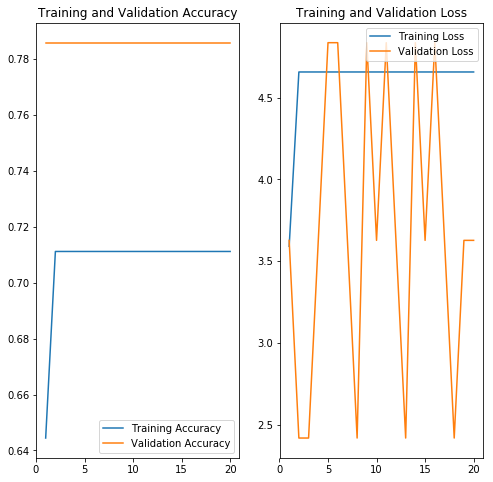

In [47]:
plotTrainVal(history_mobile, EPOCHS)

Confusion matrix, without normalization
[[0 2]
 [0 5]]


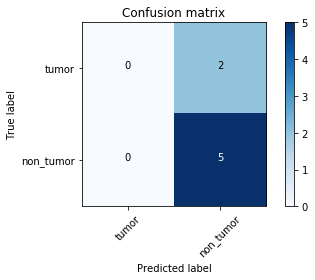

In [48]:
predictions_mobile = model_mobile.predict(sample_test_images)
y_pred_1= np.argmax(predictions_mobile, axis=1)

confusion_matrix_mobile = confusion_matrix(np.argmax(sample_test_labels, axis=1), y_pred_1)
plot_confusion_matrix(confusion_matrix_mobile, CLASS_NAMES)

### Saving Model to GCP

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.cloud import storage

CLIENT = storage.Client(project=GCP_PROJECT_ID)
BUCKET_ = CLIENT.bucket(GCP_BUCKET_NAME)

def save_model_to_gcp(model, model_name):
   
  
  # Save Keras ModelCheckpoints locally
  model.save(os.path.join("/tmp", model_name))


  # Copy over to Google Cloud Storage
  BLOB_DESTINATION = os.path.join("model", model_name)
  blob = BUCKET_.blob(BLOB_DESTINATION)
  blob.upload_from_filename(os.path.join("/tmp", model_name))
  
  # gcs url to uploaded matplotlib image
  url = blob.public_url
  
  print("Model saved at {}".format(url))

W0512 19:18:55.907488 140130952456064 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [0]:
model_name = "level{}_window_{}.h5".format(LEVEL, WINDOW)
save_model_to_gcp(model_mobile, model_name)

Model saved at https://storage.googleapis.com/vaa2114_dl_2019/model/level5_window_400.h5


### Load and Test Model

In [0]:
LOCAL_MODEL_DIR = "/tmp/model"

In [0]:
!gsutil -m cp gs://{GCP_BUCKET_NAME}/model/{model_name} {LOCAL_MODEL_DIR}/{model_name}

Copying gs://vaa2114_dl_2019/model/level5_window_400.h5...
- [1/1 files][ 75.8 MiB/ 75.8 MiB] 100% Done                                    
Operation completed over 1 objects/75.8 MiB.                                     


In [0]:
loaded_model = load_model("{}/{}".format(LOCAL_MODEL_DIR, model_name))

Confusion matrix, without normalization
[[25  2]
 [ 5  0]]


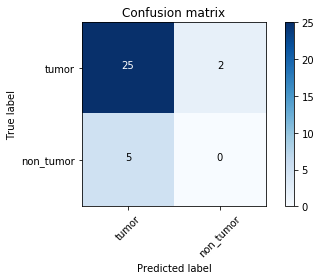

In [0]:
predictions_new = loaded_model.predict(sample_test_images)
y_preds= np.argmax(predictions_new, axis=1)

confusion_matrix_new = confusion_matrix(np.argmax(sample_test_labels, axis=1), y_preds)
plot_confusion_matrix(confusion_matrix_new, CLASS_NAMES)